In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

Std=6e-2
Std_s=132075226
t_last= 1 #4.2e5


df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
X=df.iloc[:,1]
X=np.array(X.tolist()).reshape(-1,1)
Y=df.iloc[:,2]
Y=np.array(Y.tolist()).reshape(-1,1)
S=df.iloc[:,3]
S=np.array(S.tolist()).reshape(-1,1)
Cor=np.column_stack([X,Y])
Cor=Cor/Std
S=S/Std_s

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...

'build' took 0.172832 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.320870 s

Training model...

Step      Train loss    Test loss     Test metric
0         [9.43e-02]    [9.24e-02]    []  
1000      [3.94e-03]    [3.99e-03]    []  
2000      [1.49e-03]    [1.09e-03]    []  
3000      [7.81e-05]    [7.68e-05]    []  
4000      [2.81e-05]    [2.45e-05]    []  
5000      [1.22e-05]    [1.49e-05]    []  
6000      [6.72e-06]    [1.25e-05]    []  
7000      [4.62e-06]    [1.15e-05]    []  
8000      [4.10e-06]    [1.09e-05]    []  
9000      [2.80e-06]    [9.80e-06]    []  
10000     [4.76e-06]    [1.08e-05]    []  

Best model at step 9000:
  train loss: 2.80e-06
  test loss: 9.80e-06
  test metric: []

'train' took 7.965229 s

Saving loss history to c:\Users\yesda\Documents\GitHub\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\Documents\GitHub\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\Documents\GitHub\PINN_testing\test.dat ...


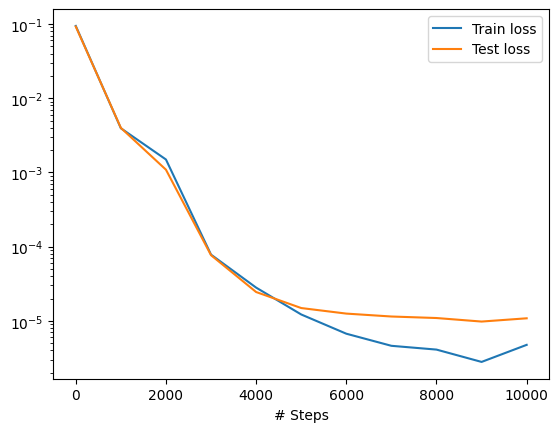

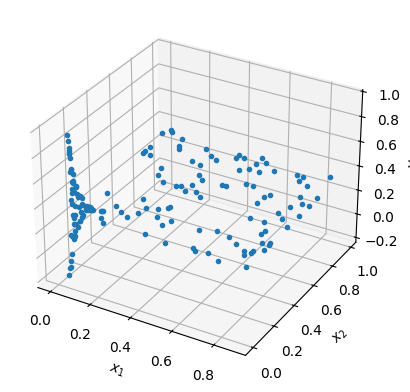

Mean Absolute Percentage Error: 1.84%
R² Score: 1.00


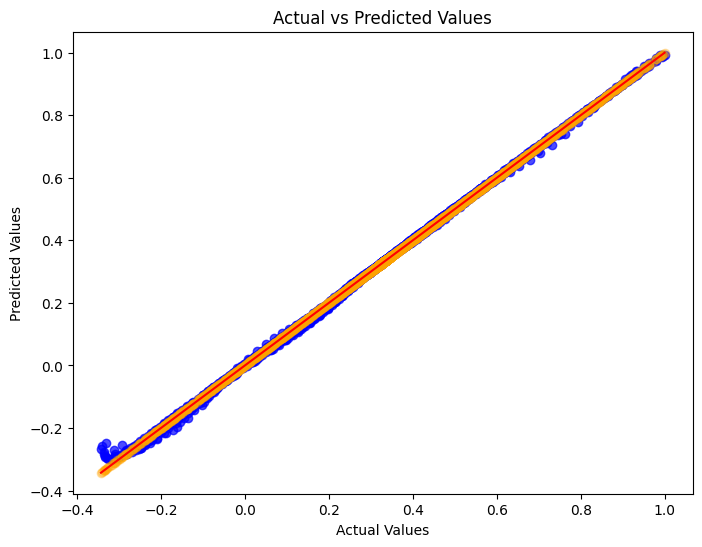

In [1]:


# Sample n points randomly from the DataFrame
n = 400  # Specify how many points you want to sample
sampled_data = df.sample(n=n)
# Split the data into training (60%) and testing (40%)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
# Training data
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training
# Testing data
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for testing

data_x=np.column_stack((x_train,y_train))/Std
data_sigma=np.array(sigma_train)/Std_s
test_x=np.column_stack((x_test,y_test))/Std
test_sigma=np.array(sigma_test)/Std_s


# Apply StandardScaler to the training and testing data
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)
layer_size = [2] + [60] * 5 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
model_sigma = dde.Model(data, net_sigma) # Define the model
model_sigma.compile("adam", lr=1e-4) # Compile the model with data
losshistory, train_state = model_sigma.train(epochs=10000) # Train the model
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Get predictions on test data
S_p = model_sigma.predict(Cor)
S_t=df.iloc[:,3]
S_t=np.array(S_t.tolist()).reshape(-1,1)
S_t=S_t/Std_s
mape = mean_absolute_percentage_error(S_t, S_p) * 100 # Calculate Mean Absolute Percentage Error (MAPE)
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
r2 = r2_score(S_t, S_p) # Calculate R² Score
print(f"R² Score: {r2:.2f}")

# Plot the actual vs predicted values for test data
plt.figure(figsize=(8, 6))
plt.scatter(S_t, S_p, alpha=0.7, color='blue', label='Predicted Values') # Scatter plot for actual values
plt.scatter(S_t, S_t, alpha=0.3, color='orange', label='Actual Values')# Scatter plot for testing data (Actual Values)
plt.plot([min(S_t), max(S_t)], [min(S_t), max(S_t)], color='red')  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

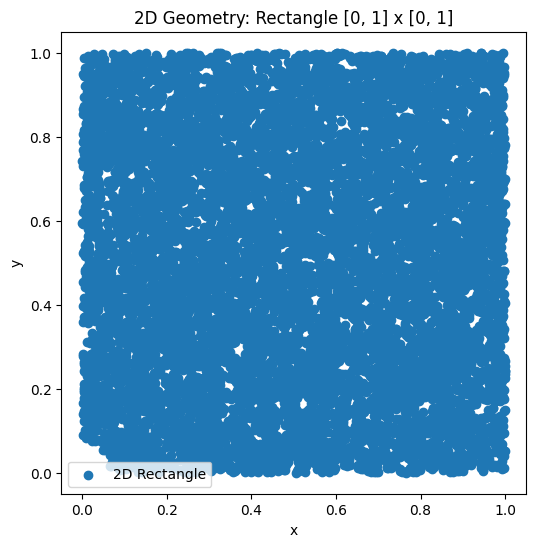

In [3]:
L = 6e-2/Std
R= 4e-3/Std

square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)

geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [83]:
data_points=Cor
grad_sigma_x = []
grad_sigma_y = []
grad_sigma_xx=[]
grad_sigma_yy=[]

ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial, component=0)
def upper_edge(x, on_boundary):
    return on_boundary and x[1]==L #x[1]=y coordinates
bc= dde.icbc.DirichletBC(geomtime, lambda x: 1e8/3, upper_edge,component=1)

def pde_C_L(x, y):
    # Parameters D_L = 1, V_H = 1, RT = 1 are given
    D_L = 3.8e-11/(Std)**2
    V_H = 2e-6
    RT= 8.314*298
    Coe=(D_L*V_H*Std_s)/(RT*Std**2)
    C_L=y[:,0:1]
    GS =y[:,1:2]
    # Gradients (partial derivatives)
    dC_L_dt = dde.grad.jacobian(C_L, x, i=0, j=2)  # ∂C_L/∂t (time derivative)
    CL_x=dde.grad.jacobian( C_L, x, i=0, j=0)
    CL_y=dde.grad.jacobian( C_L, x, i=0, j=1)
    CL_x2=dde.grad.hessian( C_L, x, i=0, j=0)
    CL_y2=dde.grad.hessian( C_L, x, i=0, j=1)
    grad_sigma_x2=dde.grad.jacobian(GS,x,i=0,j=0)
    grad_sigma_y2= dde.grad.jacobian(GS,x,i=0,j=1)
    grad_sigma_xx2=dde.grad.hessian(GS,x,i=0,j=0)
    grad_sigma_yy2=dde.grad.hessian(GS,x,i=0,j=1)
    grad_sigma_t=dde.grad.jacobian(GS,x,i=0,j=2)

    eq1 = dC_L_dt/4.2e5 - D_L*(CL_x2+CL_y2)+(Coe)*(CL_x* grad_sigma_x2+Std_s*C_L* grad_sigma_xx2+CL_y* grad_sigma_y2+Std_s*C_L*grad_sigma_yy2)
    eq2= grad_sigma_t
    return [eq1, eq2]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L,[ic,bc],
    num_boundary=400,
    num_initial=700,
    num_test=500,
    )

# Network for C_L
layer_size = [3] + [64] * 10 + [2]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-5)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=50000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.173854 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.804386 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.27e-01, 1.11e-03, 3.94e+02, 1.11e+15]    [7.24e-01, 4.13e-04, 3.94e+02, 1.11e+15]    []  


KeyboardInterrupt: 

In [40]:
p=model.predict([[0.1,0.5,0.5]])
print(p)
p=model.predict([[0.1,0.2,0.8]])
print(p)
p=model.predict([[0.2,0.5,0.7]])
print(p)

[[19.999994 43.6992  ]]
[[19.999994 43.6992  ]]
[[19.999994 43.6992  ]]


In [45]:

import matplotlib.pyplot as plt
import imageio

# Assume you have already trained the model and now you're making predictions.

# Define the geometry (Square Plate)
L = 1.0
geom = dde.geometry.Rectangle([0, 0], [L, L])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Set up a grid for prediction (x, y)
x_coords = np.linspace(0, L, 100)
y_coords = np.linspace(0, L, 100)
X, Y = np.meshgrid(x_coords, y_coords)

# Define time steps for the animation
time_steps = np.linspace(0, 1, 100)  # 100 time steps from t=0 to t=1

# Create an array to store predictions for each time step
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop over time steps and generate predictions for the model
for t_idx, t in enumerate(time_steps):
    for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
        input_data = np.array([[x, y, t]])
        prediction = model.predict(input_data)[0][0]  # Extract the C_L prediction
        predictions[i % len(x_coords), i // len(x_coords), t_idx] = prediction

# Create and save the animation using imageio
frames = []

for t_idx, t in enumerate(time_steps):
    fig, ax = plt.subplots()
    cax = ax.contourf(X, Y, predictions[:, :, t_idx], levels=100, cmap='viridis')
    ax.set_title(f"Prediction at t={t:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Save the current frame as an image
    fig.canvas.draw()  # Draw the figure so the content is updated
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)  # Close the figure to avoid memory issues

# Save as an animation using imageio
imageio.mimsave('model_prediction_animation.gif', frames, fps=10)

# Alternatively, save as an mp4 using imageio with ffmpeg plugin
imageio.mimsave('model_prediction_animation.mp4', frames, fps=10)


C:\Users\yesda\AppData\Local\Temp\ipykernel_33468\1657287650.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


In [23]:

x_coords=Cor[:,0]
y_coords=Cor[:,1]

# Load Excel data (or CSV for demonstration purposes)
df = pd.read_excel('hydrogen_concentration.xlsx') 
time = df['time'].values
time=np.array(time.tolist())/1000000
x_coords = np.ravel(np.array(x_coords).reshape([1,-1]))
y_coords = np.ravel(np.array(y_coords).reshape([1,-1]))
time_steps = np.ravel(np.array(time).reshape([1,-1]))  # Example time steps
predictions = np.zeros((len(x_coords), len(y_coords), len(time_steps)))

# Loop through each time step
for t_idx, t in enumerate(time_steps):
    # Loop through all (x, y) combinations
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        input_data = np.array([x, y, t]) 
        # Make the prediction for this (x, y, t) combination
        prediction = model.predict([input_data])[0][0]
        print(f"Prediction for (x={x}, y={y}, t={t}): {prediction}")
        # Extract the scalar prediction value (ensure it's not a sequence)
        predictions[:,i,t_idx]=prediction
        # Store the prediction in the correct location

predictions=np.array(predictions[0]).T        
print(predictions)  

import os
def delete_file(filepath):
    # Check if the file exists
    if os.path.exists(filepath):
        try:
            # Delete the file
            os.remove(filepath)
            print(f"File {filepath} successfully deleted.")
        except Exception as e:
            print(f"Error deleting file {filepath}: {e}")
    else:
        print(f"File {filepath} does not exist.")
filepath = "predictions_output.xlsx"

# Delete the file
delete_file(filepath)

print(predictions)
# Flatten the x_coords and y_coords arrays for labeling the columns
x_coords_flat = np.ravel(x_coords)
y_coords_flat = np.ravel(y_coords)

# Prepare column labels as "(x, y)" pairs
column_labels = [f"node_{i+1}" for i in range(len(x_coords_flat))]

# Create a Pandas DataFrame with time steps as rows and (x, y) as columns
df = pd.DataFrame(predictions, columns=column_labels)

# Add a "Time" column to label the time steps
df.insert(0,"time", (time_steps.flatten())*1000000)

# Export the DataFrame to an Excel file
df.to_excel("predictions_output.xlsx", index=False)

print("Data has been successfully exported to predictions_output.xlsx")


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the two Excel files, skipping the first row and first column
df1 = pd.read_excel('hydrogen_concentration.xlsx').iloc[2:, 1:]
df2 = pd.read_excel('predictions_output.xlsx').iloc[2:, 1:]

# Ensure the data is aligned by resetting the indices
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Convert the dataframes to NumPy arrays for easy comparison
data1 = df1.to_numpy()
data2 = df2.to_numpy()

# Calculate similarity metrics
mse = mean_squared_error(data1, data2)
mae = mean_absolute_error(data1, data2)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, compute element-wise absolute differences
difference = abs(data1 - data2)
print(f"Max Absolute Difference: {difference.max()}")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df3 = pd.read_excel('hydrogen_concentration.xlsx')  # First dataset
df4 = pd.read_excel('predictions_output.xlsx')  # Second dataset



# Heatmap for Dataset 1
plt.figure(figsize=(12, 8))
sns.heatmap(df3.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 1 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

# Heatmap for Dataset 2
plt.figure(figsize=(12, 8))
sns.heatmap(df4.set_index('time').T, cmap="YlGnBu", cbar_kws={'label': 'Value'})
plt.title("Heatmap of Dataset 2 (Values per Node over Time)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()

df_diff = df3.set_index('time') - df4.set_index('time')
# Heatmap for the Difference
plt.figure(figsize=(12, 8))
sns.heatmap(df_diff.T, cmap="coolwarm", cbar_kws={'label': 'Difference'})
plt.title("Heatmap of Difference (Dataset 1 - Dataset 2)")
plt.xlabel("Time")
plt.ylabel("Nodes")
plt.show()



Prediction for (x=0.24329999833333335, y=0.23520000666666668, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.26845218000000004, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.3017043383333333, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.3349565283333334, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.3682086866666667, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.40146087666666663, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.434713035, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.46796522333333335, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.5012173833333333, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.5344695716666668, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.5677217616666667, t=0.0): 20.0000057220459
Prediction for (x=0.24329999833333335, y=0.60097389, t=0.

KeyboardInterrupt: 